In [1]:
import gc
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread, imsave
from skimage.transform import resize
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from matplotlib import rcParams
import cv2


# Загрузка изображений и масок

In [3]:
images = []
lesions = []

root = '/kaggle/input/ph2dataset/PH2Dataset/PH2_Dataset'

for dirpath, dirnames, filenames in os.walk(root):
    for dirname in dirnames:
        full_dir_path = os.path.join(dirpath, dirname)
        if dirname.endswith('_Dermoscopic_Image'):
            image_files = [f for f in os.listdir(full_dir_path) if os.path.isfile(os.path.join(full_dir_path, f))]
            for file in image_files:
                images.append(imread(os.path.join(full_dir_path, file)))
        elif dirname.endswith('_lesion'):
            lesion_files = [f for f in os.listdir(full_dir_path) if os.path.isfile(os.path.join(full_dir_path, f))]
            for file in lesion_files:
                lesions.append(imread(os.path.join(full_dir_path, file)))


In [4]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

print(f'Loaded {len(X)} images')

Loaded 200 images


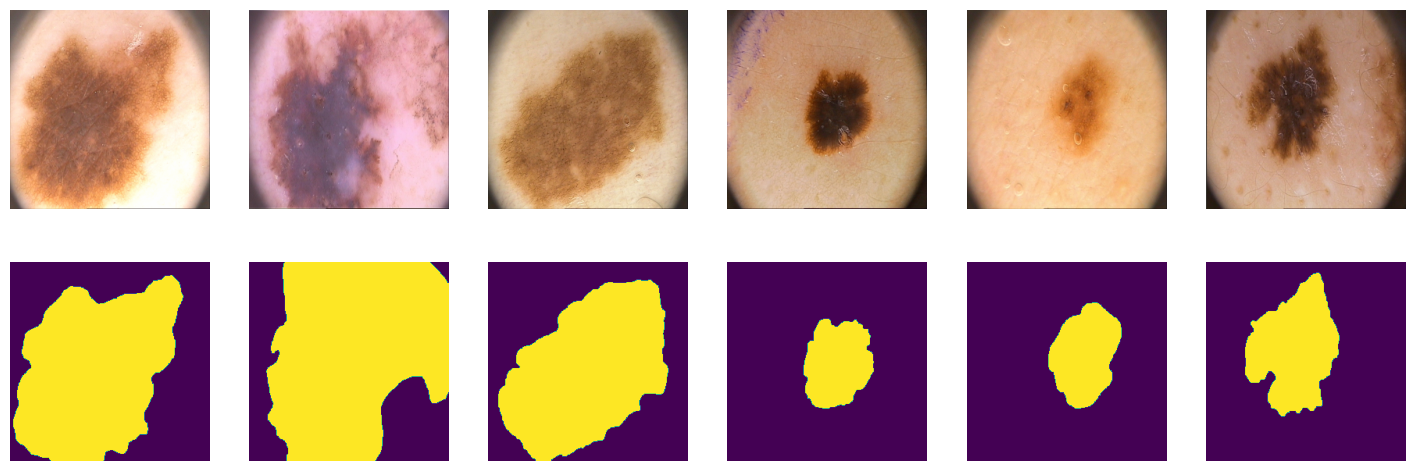

In [5]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

# Разбиение на тренировочную и валидационную выборки

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, _ = np.split(ix, [170, 200])
print(len(tr), len(val), len(_))

170 30 0


In [7]:
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
rcParams['figure.figsize'] = (15,4)

# Создание BlockBilderа

In [11]:
class BlockBuilder:
    
    @staticmethod
    def create_enc_dec_block(in_dim: int, out_dim: int, is_last=False) -> nn.Sequential:
        block = []
        block.append(
            nn.Sequential(
                nn.Conv2d(in_channels=in_dim, out_channels=out_dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(num_features=out_dim),
                nn.ReLU()
            )
        )
        if is_last:
            block.append(
                nn.Conv2d(in_channels=out_dim, out_channels=1, kernel_size=3, padding=1)
            )
        else:
            block.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=out_dim, out_channels=out_dim, kernel_size=3, padding=1),
                    nn.BatchNorm2d(num_features=out_dim),
                    nn.ReLU()
                )    
            )

        return nn.Sequential(*block)
    
    @staticmethod
    def create_pool_block(is_unpool=False, return_indices=True):
        if is_unpool:
            block = nn.MaxUnpool2d(2, stride=2)
        else:
            block = nn.MaxPool2d(2, stride=2, return_indices=return_indices)
            
        return block

In [12]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        builder = BlockBuilder()
        
        # contracting
        self.enc_conv0 = builder.create_enc_dec_block(3, 64)
        self.pool0 = builder.create_pool_block(return_indices=False)
        self.enc_conv1 = builder.create_enc_dec_block(64, 128)
        self.pool1 = builder.create_pool_block(return_indices=False)
        self.enc_conv2 = builder.create_enc_dec_block(128, 256)
        self.pool2 = builder.create_pool_block(return_indices=False)
        self.enc_conv3 = builder.create_enc_dec_block(256, 512)
        self.pool3 = builder.create_pool_block(return_indices=False)

        self.bottleneck_conv = builder.create_enc_dec_block(512, 1024)

        # expanding
        self.upsample0 = nn.Upsample(32)
        self.dec_conv0 = builder.create_enc_dec_block(1024+512, 512)
        self.upsample1 = nn.Upsample(64)
        self.dec_conv1 = builder.create_enc_dec_block(512+256, 256)
        self.upsample2 = nn.Upsample(128)
        self.dec_conv2 = builder.create_enc_dec_block(256+128, 128)
        self.upsample3 = nn.Upsample(256)
        self.dec_conv3 = builder.create_enc_dec_block(128+64, 32, True)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))
        
        # upsampling и конкатенируем с картами признаков из первого этапа.
        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)
        
        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)  # no activation
        return d3

# Обучение

In [ ]:
# функция для проверки схожести изображений
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2)) 
    union = (outputs | labels).float().sum((1, 2))        
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    
    return thresholded

In [13]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    loss_train = []
    loss_test = []
    iou_train = []
    iou_test = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_iou = 0
        model.train()  
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device) 

            opt.zero_grad()

            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) 
            loss.backward()  
            opt.step() 

            Y_pred = torch.sigmoid(Y_pred)
            Y_pred = torch.where(Y_pred > 0.5, 1, 0) # пороговое значение 0.5

            avg_iou += iou_pytorch(Y_pred, Y_batch).mean().item() / len(data_tr)

            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        loss_train.append(avg_loss.detach().cpu())
        iou_train.append(avg_iou)

        with torch.no_grad():
            model.eval() 
            X_val = X_val.to(device)
            Y_hat = model(X_val)
            Y_hat = torch.where(Y_hat > 0.5, 1, 0)
            Y_hat = Y_hat.detach().cpu()
            X_val = X_val.cpu()
            epoch_loss_test = loss_fn(Y_val, Y_hat)
            epoch_iou_test = iou_pytorch(Y_hat, Y_val).mean().item()
            iou_test.append(epoch_iou_test)
            loss_test.append(epoch_loss_test)

        # Visualize tools
        clear_output(wait=True)
        Y_hat = Y_hat.detach().numpy()
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    loss_train = list(map(lambda x: x.item(), loss_train))
    loss_test = list(map(lambda x: x.item(), loss_test))
    iou_train = iou_train
    iou_test = iou_test
    return loss_train, loss_test, iou_train, iou_test

In [14]:
# бинарная функция потерь для хорошей сходимости
def bce_loss(y_real, y_pred, e=1e-10):
    result = torch.mean(
        y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred) + e)
    )
    return result

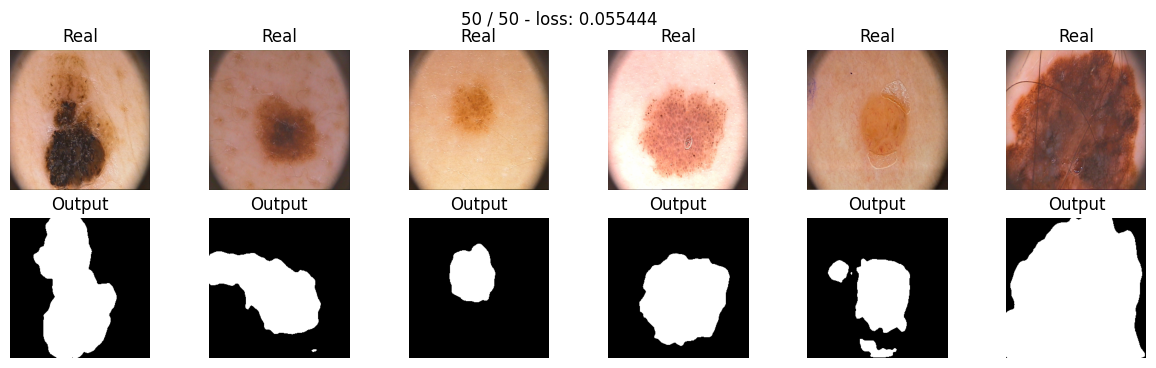

In [18]:
unet_model = UNet().to(device)
max_epochs = 50
optimizer = torch.optim.Adam(unet_model.parameters(), lr = 1e-4)
loss_train, loss_test, iou_train, iou_test = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [30]:
torch.save(unet_model.state_dict(), 'model_weights.pth')

# Применение масок к датасету

In [6]:
unet_model = UNet().to(device)

# Загрузка весов в модель
unet_model.load_state_dict(torch.load('/kaggle/input/weight2/model_weights (2).pth'))
unet_model.eval()

UNet(
  (enc_conv0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()


In [26]:

class ImageFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                            if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = imread(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Возвращаем путь для использования при сохранении предсказаний


def transform(image):
    image = resize(image, (256, 256), anti_aliasing=True) 
    image = np.rollaxis(image, 2, 0)  # Перекладываем каналы
    return image

# Создаем объект Dataset и DataLoader
folder_path = '/kaggle/input/datasetmel2/dataset/train/symmetric'
dataset = ImageFolderDataset(folder_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=2, shuffle=False)


In [27]:

def get_predictions_and_save(model, dataloader, save_dir, device='cpu'):
    model.eval()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    with torch.no_grad():
        for images, img_paths in dataloader:
            images = images.to(device, dtype=torch.float)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = preds > 0.7

            preds = preds.cpu().numpy()
            for pred, img_path in zip(preds, img_paths):
                filename = os.path.join(save_dir, os.path.basename(img_path))
                imsave(filename, pred[0])  # Сохраняем первую маску (бинарная)

save_dir = 'predictions'
get_predictions_and_save(unet_model, data_loader, save_dir, device=device)


/tmp/ipykernel_34/3141654052.py:19: UserWarning: predictions/1_410.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(filename, pred[0])  # Сохраняем первую маску (бинарная)
/tmp/ipykernel_34/3141654052.py:19: UserWarning: predictions/2_new_805_1.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(filename, pred[0])  # Сохраняем первую маску (бинарная)
/tmp/ipykernel_34/3141654052.py:19: UserWarning: predictions/1_new_1300.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(filename, pred[0])  # Сохраняем первую маску (бинарная)
/tmp/ipykernel_34/3141654052.py:19: UserWarning: predictions/1_3133.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  ims

In [28]:
images_folder = '/kaggle/input/datasetmel2/dataset/train/symmetric'
masks_folder = '/kaggle/working/predictions'
output_folder = '/kaggle/working/train/symmetric'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for img_name in os.listdir(images_folder):
    img_path = os.path.join(images_folder, img_name)
    mask_path = os.path.join(masks_folder, img_name)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    mask_resized = cv2.resize(mask, (256, 256))

    img_resized = cv2.resize(img, (256, 256))

    masked_img = cv2.bitwise_and(img_resized, img_resized, mask=mask_resized)

    save_path = os.path.join(output_folder, img_name)
    cv2.imwrite(save_path, masked_img)

In [29]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/predictions/ (stored 0%)
  adding: kaggle/working/predictions/1_2270.jpg (deflated 14%)
  adding: kaggle/working/predictions/2_2922.jpg (deflated 8%)
  adding: kaggle/working/predictions/1_new_758.jpg (deflated 15%)
  adding: kaggle/working/predictions/2_1298.jpg (deflated 30%)
  adding: kaggle/working/predictions/2_new_764.jpg (deflated 30%)
  adding: kaggle/working/predictions/2_new_699.jpg (deflated 19%)
  adding: kaggle/working/predictions/2_new_1324.jpg (deflated 25%)
  adding: kaggle/working/predictions/1_2786.jpg (deflated 16%)
  adding: kaggle/working/predictions/2_new_865_1.jpg (deflated 13%)
  adding: kaggle/working/predictions/1_940.jpg (deflated 12%)
  adding: kaggle/working/predictions/1_1007.jpg (deflated 41%)
  adding: kaggle/working/predictions/2_768.jpg (deflated 14%)
  adding: kaggle/working/predictions/1_new_608.jpg (deflated 17%)
  adding: kaggle/working/predictions/2_3143.jpg (deflated 17%)
  adding: ka

In [1]:
import os
import shutil

# Получаем список файлов и директорий в /kaggle/working/
files = os.listdir('/kaggle/working/')

# Удаляем каждый файл и директорию
for file in files:
    if os.path.isfile(file):
        os.remove(file)  # Удалить файл
    else:
        shutil.rmtree(file)  # Удалить директорию
